In [1]:
%run ./GymDFBRPSimulator.ipynb

Start time: 02:13:57
End time: 11:46:38
Time difference is 34361.0 seconds
Time difference is 34361000.0 milliseconds


In [2]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pettingzoo
from pettingzoo import AECEnv
from pettingzoo.utils import agent_selector, wrappers

In [3]:
class raw_env(AECEnv):
    def __init__(self, *args, **kwargs):
        super().__init__()
        self.metadata = {'render_modes': ['human'], "name": "BusRouting-v0"}
        
        self.busHandler = GymDFBRPSimulator(kwargs["numberOfBuses"],kwargs["numberOfRequests"],rendermode=kwargs["render_mode"])
        self.numberOfBuses = kwargs["numberOfBuses"]
        self.numberOfRequests = kwargs["numberOfRequests"]

        self.agents = [str(i) for i in range(self.numberOfBuses)]
        self.possible_agents = self.agents[:]
        self._agent_selector = agent_selector(self.agents)
       
        action_space = [spaces.Discrete((1)+(self.busHandler.getCapacity()*self.busHandler.getCapacity()*4)) for agent in self.agents] #Consider a single  space 
        self.action_spaces = dict(zip(self.agents, action_space))

        self._initActionMap(self.busHandler.getCapacity()) #Initialize the action map

        self.previousRewardDistance = np.zeros(self.numberOfBuses)
        self.previousRewardTime = np.zeros(self.numberOfBuses)

        highestCord = math.ceil(max(self.busHandler.getLargestLatitude()-self.busHandler.getSmallestLatitude(),self.busHandler.getLargestLongitude()-self.busHandler.getSmallestLongitude())) 
        requestHigh = np.array([highestCord,highestCord,highestCord,highestCord,4,self.numberOfRequests])
        busesLocationsHigh = np.array([highestCord for _ in range(self.numberOfBuses*2)])
        passengerCountsHigh = np.array([self.busHandler.getCapacity() for _ in range(self.numberOfBuses)])
        busesRoutesHigh = np.array([highestCord for _ in range(self.numberOfBuses*self.busHandler.getCapacity()*2*2)])
        busDistancesHigh = np.array([math.inf for _ in range(self.numberOfBuses)])
        high = np.concatenate((self.numberOfRequests,1,requestHigh,busesLocationsHigh,passengerCountsHigh,busDistancesHigh,busesRoutesHigh),axis=None)
        low = np.concatenate(np.array([-1 for _ in range(8+(self.numberOfBuses*2)+self.numberOfBuses+self.numberOfBuses+(self.numberOfBuses*self.busHandler.getCapacity()*2*2))]),axis=None)
        # print("High",high)
        # print("Low",low)
        # print("High Shape",high.shape)
        # print("Low Shape",low.shape)
        self.observation_spaces = {
            agent: spaces.Dict({
                "observation": spaces.Box(low=low, high=high, shape=(8+(self.numberOfBuses*2)+self.numberOfBuses+self.numberOfBuses+(self.numberOfBuses*self.busHandler.getCapacity()*2*2),), dtype=np.float32), #0-5 Request, 5-NumberOfBuses, NumberOfBuses, Routes 
                # "observation": spaces.Dict({
                #     "request": spaces.Box(low=0, high=90, shape=(5,), dtype=np.float32), 
                #     "buses": spaces.Dict({
                #         "locations": spaces.Box(low=0, high=90, shape=(self.numberOfBuses,2), dtype=np.float32),
                #         "passenger_counts"
                
                # }),
                "action_mask": spaces.Box(0,1, shape=((1)+(self.busHandler.getCapacity()*2*self.busHandler.getCapacity()*2),), dtype=np.int8)
            })  for agent in self.agents
        }

        self.rewards = {agent: 0 for agent in self.agents}
        self.terminations = {agent: False for agent in self.agents}
        self.truncations = {agent: False for agent in self.agents}
        self.infos = {agent: {} for agent in self.agents}
        self.agent_selection = None

        assert kwargs["render_mode"] is None or kwargs["render_mode"] in self.metadata["render_modes"] #Ensure that the render mode selected is validd
        self.render_mode = kwargs["render_mode"]

    def observation_space(self, agent):
        return self.observation_spaces[agent]
    
    def action_space(self, agent):
        return self.action_spaces[agent]

    def _get_obs(self,agent):
        # state = {"request": self.busHandler.getRequestObservation(), "buses": {"locations": self.busHandler.getBusesLocationsObservation(), "passenger_counts": self.busHandler.getPassengerCountsObservation(), "routes": self.busHandler.getBusesRoutesObservation()}}
        requests = self.busHandler.getRequestObservation()
        busesLocations = self.busHandler.getBusesLocationsObservation()
        passengerCounts = self.busHandler.getPassengerCountsObservation()
        busesRoutes = self.busHandler.getBusesRoutesObservation()
        busDistances = self.busHandler.getBusesDistancesObservation()

        #Create an np zeros array of the following format: (5+(self.numberOfBuses*2)+self.numberOfBuses+(self.numberOfBuses*self.busHandler.getCapacity()*2),
        state = np.zeros((8+(self.numberOfBuses*2)+self.numberOfBuses+self.numberOfBuses+(self.numberOfBuses*2*2*self.busHandler.getCapacity()),), dtype=np.float32)
        state[0] = len(self.busHandler.rejectedRequests)
        if self.busHandler.getHandledRequest():
            state[1] = 1
        state[2:8] = requests
        state[8:8+(self.numberOfBuses*2)] = busesLocations.flatten()
        state[8+(self.numberOfBuses*2):8+(self.numberOfBuses*2)+self.numberOfBuses] = passengerCounts
        state[8+(self.numberOfBuses*2)+self.numberOfBuses:8+(self.numberOfBuses*2)+self.numberOfBuses+self.numberOfBuses] = busDistances
        state[8+(self.numberOfBuses*2)+self.numberOfBuses+self.numberOfBuses:] = busesRoutes.flatten()

        action_mask = self._getIllegalMask(agent)  
        obs = {"observation": state, "action_mask": action_mask}
        return obs
    def _get_info(self):
        return{
            "distance": self.busHandler.getTotalDistance(),
            "time": self.busHandler.getTotalTime()
        }
    # def _render_frame(self):
    #     if self.render_mode == "human":
    #         self.busHandler.renderRoutes()

    def _initActionMap(self,vehicleCapacity):
        self.actionMap = {}
        counter = 0
        self.actionMap[counter] = [REJECTED,0,0]
        counter += 1
        for j in range(vehicleCapacity*2):
            for k in range(vehicleCapacity*2):
                self.actionMap[counter] = [ACCEPTED,j,k]
                counter += 1
    def _getIllegalMask(self,agent):
        mask = np.zeros(len(self.actionMap),dtype=np.int8)
        for i in range(len(self.actionMap)):
            if self._illegalAction(i,agent)==True:
                mask[i] = 0
            else:
                mask[i] = 1
        return mask

    def _illegalAction(self,action,agent):
        # print("Action",action)
        mappedAction = self.actionMap[action]
        vehicleIndex = int(agent)
        if mappedAction[0] == REJECTED:
            if mappedAction[1] == 0 and mappedAction[2] == 0:
                return False
            return True

        if self.busHandler.getHandledRequest()==True and mappedAction[0] == ACCEPTED:
            return True

        #Capacity Check
        if self.busHandler.vehicles[vehicleIndex].getCurrentLoad() + self.busHandler.currentRequest.getPassengerAmount() > self.busHandler.vehicles[vehicleIndex].getCapacity():
            return True
        
        #Correct indexes order check
        if mappedAction[DESTINATION_INDEX] <= mappedAction[ORIGIN_INDEX]:
            return True
        
        if mappedAction[ORIGIN_INDEX] > self.busHandler.vehicles[vehicleIndex].getCurrentLoad():
            return True
        
        if mappedAction[DESTINATION_INDEX] > self.busHandler.vehicles[vehicleIndex].getCurrentLoad()+1:
            return True
        
        return False
        
    def observe(self, agent):
        return self._get_obs(agent)
    
    def reset(self, seed=None, options=None,return_info=False):
        self.busHandler.reset()
        # if self.render_mode == "human":
        #     # self.busHandler._clearMap()
        #     # self._render_frame()
        
        self.agents = self.possible_agents[:]
        self._agent_selector = agent_selector(self.agents)
        self.agent_selection = self._agent_selector.reset()

        self.rewards = {agent: 0 for agent in self.agents}
        self._cumulative_rewards = {agent: 0 for agent in self.agents}
        self.terminations = {agent: False for agent in self.agents}
        self.truncations = {agent: False for agent in self.agents}
        self.infos = {agent: {} for agent in self.agents}
        self.num_steps = 0
        self.lastActionAgent = None
    
    def render(self):
        pass

    def close(self):
        pass

    def step(self,action):
        if (self.terminations[self.agent_selection] or self.truncations[self.agent_selection]):
            # handles stepping an agent which is already dead
            # accepts a None action for the one agent, and moves the agent_selection to
            # the next dead agent,  or if there are no more dead agents, to the next live agent
            self._was_dead_step(action)
            return
    
        current_agent = self.agent_selection
        if self._illegalAction(action, current_agent):
            print("Illegal action: "+str(action)+" for agent: "+str(current_agent))
            # raise ValueError("Illegal action: "+str(action)+" for agent: "+str(current_agent))
            self._clear_rewards()
            self._cumulative_rewards[current_agent] = 0
            self._accumulate_rewards()
            self.terminations = {agent: False for agent in self.agents}
            self.truncations = {agent: False for agent in self.agents}
            return 

        actionMapped = self.actionMap[action]

        if actionMapped[0] != REJECTED:
            self.previousRewardTime = self.busHandler.getTimeWindowsReward()
            self.busHandler.acceptRequest(int(current_agent),actionMapped[1],actionMapped[2])
        
        if self._agent_selector.is_last():
            reward = None
            if self.busHandler.getHandledRequest() == False:
                self.busHandler.rejectRequest()        
            
            if self.busHandler.getHandledRequest():
                reward = self.busHandler.getReward(ACCEPTED,self.previousRewardTime)
            else:
                reward = self.busHandler.getReward(REJECTED,self.previousRewardTime)

            self.busHandler.advanceToNextRequest()
            done = self.busHandler.endCheck()
            self.busHandler.updateState()    

            self.terminations = {agent: done for agent in self.agents}
            self.truncations = {agent: done for agent in self.agents}
            self.rewards = {agent: reward[int(agent)] for agent in self.agents}

            # if self.render_mode == "human":
            #     self._render_frame()
        else:
            self._clear_rewards()
            self.terminations = {agent: False for agent in self.agents}
            self.truncations = {agent: False for agent in self.agents}
        
        self._cumulative_rewards[current_agent] = 0
        self.agent_selection = self._agent_selector.next()
        self._accumulate_rewards()

        info = {}

testEnv = raw_env(numberOfBuses=10,numberOfRequests=50,render_mode=None)
print(testEnv.observation_space("0")["observation"].shape)
print(testEnv._get_obs("0")["observation"].shape)

print(testEnv.action_spaces["0"].n)
print(testEnv._get_obs("0")["action_mask"].shape)

getActionMask = testEnv._get_obs("0")["action_mask"]
for i in range(len(getActionMask)):
    if getActionMask[i] == 1:
        print("Action: ",i,testEnv.actionMap[i])

testEnv.reset()
for agent in testEnv.agents:
    testEnv.step(0)
print("Rewards: ",testEnv.rewards)

testEnv.reset()
for i in range(len(testEnv.agents)):
    if i == 0:
        testEnv.step(55)
    else:
        testEnv.step(0)
print("Rewards: ",testEnv.rewards)

print(testEnv._get_obs("0")["observation"])

(448,)
(448,)
401
(401,)
Action:  0 [0, 0, 0]
Action:  2 [1, 0, 1]
[-300. -300. -300. -300. -300. -300. -300. -300. -300. -300.] + 0.0 = [-300.0, -300.0, -300.0, -300.0, -300.0, -300.0, -300.0, -300.0, -300.0, -300.0]
Rewards:  {'0': -300.0, '1': -300.0, '2': -300.0, '3': -300.0, '4': -300.0, '5': -300.0, '6': -300.0, '7': -300.0, '8': -300.0, '9': -300.0}
Illegal action: 55 for agent: 0
Rewards:  {'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': 0, '6': 0, '7': 0, '8': 0, '9': 0}
[0.        0.        0.0536062 0.185928  0.0925377 0.2043119 3.
 0.        0.1067842 0.1620376 0.1067842 0.1620376 0.1067842 0.1620376
 0.1067842 0.1620376 0.1067842 0.1620376 0.1067842 0.1620376 0.1067842
 0.1620376 0.1067842 0.1620376 0.1067842 0.1620376 0.1067842 0.1620376
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.      

In [4]:
def env(**kwargs):
    """
    The env function often wraps the environment in wrappers by default.
    You can find full documentation for these methods
    elsewhere in the developer documentation.
    """
    # internal_render_mode = render_mode if render_mode != "ansi" else "human"
    env = raw_env(**kwargs)

    # this wrapper helps error handling for discrete action spaces
    env = wrappers.AssertOutOfBoundsWrapper(env)
    #Provides a wide variety of helpful user errors

    #Strongly recommended
    env = wrappers.OrderEnforcingWrapper(env)

    return env

In [5]:
from ray.rllib.env import PettingZooEnv
from ray.rllib.models import ModelCatalog
from ray.tune.registry import register_env
from ray.rllib.models.tf.fcnet import FullyConnectedNetwork
from ray.rllib.models.tf.tf_modelv2 import TFModelV2
from ray.rllib.models.torch.torch_modelv2 import TorchModelV2
from ray.rllib.models.torch.fcnet import FullyConnectedNetwork as TorchFC
from ray.rllib.utils.framework import try_import_tf, try_import_torch
from ray.rllib.utils.torch_utils import FLOAT_MIN

tf1, tf, tfv = try_import_tf()
torch, nn = try_import_torch()

class ActionMaskModel(TFModelV2):
    """Model that handles simple discrete action masking.
    This assumes the outputs are logits for a single Categorical action dist.
    Getting this to work with a more complex output (e.g., if the action space
    is a tuple of several distributions) is also possible but left as an
    exercise to the reader.
    """

    def __init__(
        self, obs_space, action_space, num_outputs, model_config, name, **kwargs
    ):

        orig_space = getattr(obs_space, "original_space", obs_space)
        assert (
            isinstance(orig_space, spaces.Dict)
            and "action_mask" in orig_space.spaces
            and "observation" in orig_space.spaces
        )

        super().__init__(obs_space, action_space, num_outputs, model_config, name)

        self.internal_model = FullyConnectedNetwork(
            orig_space["observation"],
            action_space,
            num_outputs,
            model_config,
            name + "_internal",
        )

    def forward(self, input_dict, state, seq_lens):
        # Extract the available actions tensor from the observation.
        action_mask = input_dict["obs"]["action_mask"]

        # Compute the unmasked logits.
        logits, _ = self.internal_model({"obs": input_dict["obs"]["observation"]})

        # Convert action_mask into a [0.0 || -inf]-type mask.
        inf_mask = tf.maximum(tf.math.log(action_mask), tf.float32.min)
        masked_logits = logits + inf_mask

        # Return masked logits.
        return masked_logits, state

    def value_function(self):
        return self.internal_model.value_function()

ModelCatalog.register_custom_model("action_masking_model", ActionMaskModel)

def env_creator(numberOfBuses=10,numberOfRequests=50,render_mode=None):
    env2 = env(numberOfBuses=numberOfBuses,numberOfRequests=numberOfRequests,render_mode=render_mode)
    return env2

register_env("busHandler-T1", lambda config: PettingZooEnv(env_creator(numberOfBuses=5,numberOfRequests=50,render_mode=None)))
register_env("busHandler-T2", lambda config: PettingZooEnv(env_creator(numberOfBuses=5,numberOfRequests=150,render_mode=None)))
register_env("busHandler-T3", lambda config: PettingZooEnv(env_creator(numberOfBuses=5,numberOfRequests=500,render_mode=None)))
register_env("busHandler-T4", lambda config: PettingZooEnv(env_creator(numberOfBuses=5,numberOfRequests=1000,render_mode=None)))
register_env("busHandler-T5", lambda config: PettingZooEnv(env_creator(numberOfBuses=10,numberOfRequests=50,render_mode=None)))
register_env("busHandler-T6", lambda config: PettingZooEnv(env_creator(numberOfBuses=10,numberOfRequests=150,render_mode=None)))
register_env("busHandler-T7", lambda config: PettingZooEnv(env_creator(numberOfBuses=10,numberOfRequests=500,render_mode=None)))
register_env("busHandler-T8", lambda config: PettingZooEnv(env_creator(numberOfBuses=10,numberOfRequests=1000,render_mode=None)))
register_env("busHandler-T9", lambda config: PettingZooEnv(env_creator(numberOfBuses=20,numberOfRequests=50,render_mode=None)))
register_env("busHandler-T10", lambda config: PettingZooEnv(env_creator(numberOfBuses=20,numberOfRequests=150,render_mode=None)))
register_env("busHandler-T11", lambda config: PettingZooEnv(env_creator(numberOfBuses=20,numberOfRequests=500,render_mode=None)))
register_env("busHandler-T12", lambda config: PettingZooEnv(env_creator(numberOfBuses=20,numberOfRequests=1000,render_mode=None)))

busHandlerT1 = PettingZooEnv(env_creator(numberOfBuses=5,numberOfRequests=50,render_mode=None))
busHandlerT2 = PettingZooEnv(env_creator(numberOfBuses=5,numberOfRequests=150,render_mode=None))
busHandlerT3 = PettingZooEnv(env_creator(numberOfBuses=5,numberOfRequests=500,render_mode=None))
busHandlerT4 = PettingZooEnv(env_creator(numberOfBuses=5,numberOfRequests=1000,render_mode=None))
busHandlerT5 = PettingZooEnv(env_creator(numberOfBuses=10,numberOfRequests=50,render_mode=None))
busHandlerT6 = PettingZooEnv(env_creator(numberOfBuses=10,numberOfRequests=150,render_mode=None))
busHandlerT7 = PettingZooEnv(env_creator(numberOfBuses=10,numberOfRequests=500,render_mode=None))
busHandlerT8 = PettingZooEnv(env_creator(numberOfBuses=10,numberOfRequests=1000,render_mode=None))
busHandlerT9 = PettingZooEnv(env_creator(numberOfBuses=20,numberOfRequests=50,render_mode=None))
busHandlerT10 = PettingZooEnv(env_creator(numberOfBuses=20,numberOfRequests=150,render_mode=None))
busHandlerT11 = PettingZooEnv(env_creator(numberOfBuses=20,numberOfRequests=500,render_mode=None))
busHandlerT12 = PettingZooEnv(env_creator(numberOfBuses=20,numberOfRequests=1000,render_mode=None))

busHandlerRawT1 = raw_env(numberOfBuses=5,numberOfRequests=50,render_mode=None)
busHandlerRawT2 = raw_env(numberOfBuses=5,numberOfRequests=150,render_mode=None)
busHandlerRawT3 = raw_env(numberOfBuses=5,numberOfRequests=500,render_mode=None)
busHandlerRawT4 = raw_env(numberOfBuses=5,numberOfRequests=1000,render_mode=None)
busHandlerRawT5 = raw_env(numberOfBuses=10,numberOfRequests=50,render_mode=None)
busHandlerRawT6 = raw_env(numberOfBuses=10,numberOfRequests=150,render_mode=None)
busHandlerRawT7 = raw_env(numberOfBuses=10,numberOfRequests=500,render_mode=None)
busHandlerRawT8 = raw_env(numberOfBuses=10,numberOfRequests=1000,render_mode=None)
busHandlerRawT9 = raw_env(numberOfBuses=20,numberOfRequests=50,render_mode=None)
busHandlerRawT10 = raw_env(numberOfBuses=20,numberOfRequests=150,render_mode=None)
busHandlerRawT11 = raw_env(numberOfBuses=20,numberOfRequests=500,render_mode=None)
busHandlerRawT12 = raw_env(numberOfBuses=20,numberOfRequests=1000,render_mode=None)

2024-05-25 13:04:57,783	WARNING deprecation.py:50 -- DeprecationWarning: `DirectStepOptimizer` has been deprecated. This will raise an error in the future!


In [7]:
from ray.rllib.algorithms.a2c import A2CConfig
def trainEnv(PettingZooBusHandler,rawEnv,envName,trainAmount):
    obs_space = PettingZooBusHandler.observation_space
    act_space = PettingZooBusHandler.action_space
    config = A2CConfig()
    config = config.training(lr=0.0001, grad_clip=1000000, model={"custom_model": "action_masking_model"})
    config = config.resources(num_gpus=0)
    config = config.rollouts(num_rollout_workers=1)

    config = config.multi_agent(
            policies={agent: (None, obs_space, act_space, {}) for agent in rawEnv.agents},
            policy_mapping_fn=(
                    lambda agent_id, episode, worker, **kwargs: agent_id
                ),
            policies_to_train=[agent for agent in rawEnv.agents],)
    config = config.framework(framework="tf")
    A2C = config.build(env=envName)

    for i in range(trainAmount):
        result = A2C.train()
        if i % 1 == 0:
            print(i)
        if i % 10 == 0 and i != 0:
            checkpoint = A2C.save()
            print("Episode: "+str(i))
            print("StepCount: "+str(result["timesteps_total"]))
            print(checkpoint)

    checkpoint = A2C.save()
    print(checkpoint)

In [8]:
trainEnv(busHandlerT1,busHandlerRawT1,"busHandler-T1",150) #Done
trainEnv(busHandlerT2,busHandlerRawT2,"busHandler-T2",500) #Done

In [9]:
trainEnv(busHandlerT3,busHandlerRawT3,"busHandler-T3",1000) 
trainEnv(busHandlerT4,busHandlerRawT4,"busHandler-T4",1500) 

In [10]:
trainEnv(busHandlerT5,busHandlerRawT5,"busHandler-T5",150) #Done
trainEnv(busHandlerT6,busHandlerRawT6,"busHandler-T6",750) #Done

In [11]:
trainEnv(busHandlerT7,busHandlerRawT7,"busHandler-T7",1500) 
trainEnv(busHandlerT8,busHandlerRawT8,"busHandler-T8",2000) 

In [12]:
trainEnv(busHandlerT9,busHandlerRawT9,"busHandler-T9",750) # Done
trainEnv(busHandlerT10,busHandlerRawT10,"busHandler-T10",1000) #Done

In [13]:
trainEnv(busHandlerT11,busHandlerRawT11,"busHandler-T11",2000)
trainEnv(busHandlerT12,busHandlerRawT12,"busHandler-T12",2500) 

In [14]:
from ray.rllib.algorithms.algorithm import Algorithm
import pickle

algo1 = Algorithm.from_checkpoint(r"C:\Users\lukec/ray_results\A2C_busHandler-T1_2024-05-24_03-27-10f7x1dks6\checkpoint_000150") 
algo2 = Algorithm.from_checkpoint(r"C:\Users\lukec/ray_results\A2C_busHandler-T2_2024-05-24_03-53-02760qgnop\checkpoint_000500")
algo3 = Algorithm.from_checkpoint(r"C:\Users\lukec/ray_results\A2C_busHandler-T3_2024-05-24_05-22-02oavalrt2\checkpoint_001000")
algo4 = Algorithm.from_checkpoint(r"C:\Users\lukec/ray_results\A2C_busHandler-T4_2024-05-24_08-26-46vfeh1182\checkpoint_001500") 
algo5 = Algorithm.from_checkpoint(r"C:\Users\lukec\ray_results\A2C_busHandler-T5_2024-05-24_13-07-52e0xhaaos\checkpoint_000150") 
algo6 = Algorithm.from_checkpoint(r"C:\Users\lukec/ray_results\A2C_busHandler-T6_2024-05-24_13-42-21qa022cdi\checkpoint_000750") 
algo7 = Algorithm.from_checkpoint(r"C:\Users\lukec/ray_results\A2C_busHandler-T7_2024-05-24_15-55-13uq7ugfp3\checkpoint_001500") 
algo8 = Algorithm.from_checkpoint(r"C:\Users\lukec/ray_results\A2C_busHandler-T8_2024-05-24_20-46-38nhu_jty2\checkpoint_002000")
algo9 = Algorithm.from_checkpoint(r"C:\Users\lukec/ray_results\A2C_busHandler-T9_2024-05-25_03-13-19gwafthih\checkpoint_000750")
algo10 = Algorithm.from_checkpoint(r"C:\Users\lukec/ray_results\A2C_busHandler-T10_2024-05-25_05-24-48gtaaicuw\checkpoint_001000")
algo11 = Algorithm.from_checkpoint(r"C:\Users\lukec/ray_results\A2C_busHandler-T11_2024-05-24_21-36-35n2hs828l\checkpoint_002000")
algo12 = Algorithm.from_checkpoint(r"C:\Users\lukec/ray_results\A2C_busHandler-T12_2024-05-25_04-02-23p9pmt0qp\checkpoint_002500")

2024-05-25 13:05:14,732	WARNING deprecation.py:50 -- DeprecationWarning: `rllib/algorithms/a2c/` has been deprecated. Use `rllib_contrib/a2c/` instead. This will raise an error in the future!
2024-05-25 13:05:14,732	WARNING deprecation.py:50 -- DeprecationWarning: `rllib/algorithms/a3c/` has been deprecated. Use `rllib_contrib/a3c/` instead. This will raise an error in the future!
c:\Users\lukec\anaconda3\envs\Thesis\Lib\site-packages\ray\rllib\algorithms\algorithm.py:484: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
c:\Users\lukec\anaconda3\envs\Thesis\Lib\site-packages\ray\tune\logger\unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHO

2024-05-25 13:05:18,441	INFO worker.py:1621 -- Started a local Ray instance.
(pid=48916) DeprecationWarning: `DirectStepOptimizer` has been deprecated. This will raise an error in the future!
(RolloutWorker pid=48916) 2024-05-25 13:05:34,312	WARNING deprecation.py:50 -- DeprecationWarning: `ray.rllib.models.tf.tf_modelv2.TFModelV2` has been deprecated. Use `ray.rllib.core.rl_module.RLModule` instead. This will raise an error in the future!
(RolloutWorker pid=48916) 2024-05-25 13:05:34,312	WARNING deprecation.py:50 -- DeprecationWarning: `ray.rllib.models.tf.fcnet.FullyConnectedNetwork` has been deprecated. This will raise an error in the future!
(RolloutWorker pid=48916) 2024-05-25 13:05:34,316	WARNING deprecation.py:50 -- DeprecationWarning: `ray.rllib.models.tf.misc.normc_initializer` has been deprecated. This will raise an error in the future!
(RolloutWorker pid=48916) 2024-05-25 13:05:34,383	WARNING deprecation.py:50 -- DeprecationWarning: `StochasticSampling` has been deprecated. 

(RolloutWorker pid=48916) Illegal action: 155 for agent: 0


(RolloutWorker pid=48916) 2024-05-25 13:05:34,628	WARNING deprecation.py:50 -- DeprecationWarning: `compute_gradients` has been deprecated. This will raise an error in the future!
2024-05-25 13:05:41,935	WARNING deprecation.py:50 -- DeprecationWarning: `ray.rllib.models.tf.tf_modelv2.TFModelV2` has been deprecated. Use `ray.rllib.core.rl_module.RLModule` instead. This will raise an error in the future!
2024-05-25 13:05:41,936	WARNING deprecation.py:50 -- DeprecationWarning: `ray.rllib.models.tf.fcnet.FullyConnectedNetwork` has been deprecated. This will raise an error in the future!
2024-05-25 13:05:41,942	WARNING deprecation.py:50 -- DeprecationWarning: `ray.rllib.models.tf.misc.normc_initializer` has been deprecated. This will raise an error in the future!
2024-05-25 13:05:42,031	WARNING deprecation.py:50 -- DeprecationWarning: `StochasticSampling` has been deprecated. This will raise an error in the future!
2024-05-25 13:05:42,033	WARNING deprecation.py:50 -- DeprecationWarning: `Ex

(RolloutWorker pid=3488) Illegal action: 372 for agent: 0


2024-05-25 13:06:29,269	INFO trainable.py:172 -- Trainable.setup took 37.829 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2024-05-25 13:06:29,271	WARNING util.py:68 -- Install gputil for GPU system monitoring.
(pid=33032) DeprecationWarning: `DirectStepOptimizer` has been deprecated. This will raise an error in the future!


(RolloutWorker pid=33032) Illegal action: 222 for agent: 0


(RolloutWorker pid=33032) 2024-05-25 13:06:37,847	WARNING deprecation.py:50 -- DeprecationWarning: `ray.rllib.models.tf.tf_modelv2.TFModelV2` has been deprecated. Use `ray.rllib.core.rl_module.RLModule` instead. This will raise an error in the future!
(RolloutWorker pid=33032) 2024-05-25 13:06:37,847	WARNING deprecation.py:50 -- DeprecationWarning: `ray.rllib.models.tf.fcnet.FullyConnectedNetwork` has been deprecated. This will raise an error in the future!
(RolloutWorker pid=33032) 2024-05-25 13:06:37,851	WARNING deprecation.py:50 -- DeprecationWarning: `ray.rllib.models.tf.misc.normc_initializer` has been deprecated. This will raise an error in the future!
(RolloutWorker pid=33032) 2024-05-25 13:06:37,892	WARNING deprecation.py:50 -- DeprecationWarning: `StochasticSampling` has been deprecated. This will raise an error in the future!
(RolloutWorker pid=33032) 2024-05-25 13:06:37,892	WARNING deprecation.py:50 -- DeprecationWarning: `Exploration` has been deprecated. This will raise an

(RolloutWorker pid=21024) Illegal action: 391 for agent: 0


(RolloutWorker pid=21024) 2024-05-25 13:07:21,247	WARNING deprecation.py:50 -- DeprecationWarning: `compute_gradients` has been deprecated. This will raise an error in the future!
2024-05-25 13:07:55,850	INFO trainable.py:172 -- Trainable.setup took 44.158 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2024-05-25 13:07:55,851	WARNING util.py:68 -- Install gputil for GPU system monitoring.
(pid=40380) DeprecationWarning: `DirectStepOptimizer` has been deprecated. This will raise an error in the future!


(RolloutWorker pid=40380) Illegal action: 314 for agent: 0


(RolloutWorker pid=40380) 2024-05-25 13:08:11,104	WARNING deprecation.py:50 -- DeprecationWarning: `ray.rllib.models.tf.tf_modelv2.TFModelV2` has been deprecated. Use `ray.rllib.core.rl_module.RLModule` instead. This will raise an error in the future!
(RolloutWorker pid=40380) 2024-05-25 13:08:11,105	WARNING deprecation.py:50 -- DeprecationWarning: `ray.rllib.models.tf.fcnet.FullyConnectedNetwork` has been deprecated. This will raise an error in the future!
(RolloutWorker pid=40380) 2024-05-25 13:08:11,110	WARNING deprecation.py:50 -- DeprecationWarning: `ray.rllib.models.tf.misc.normc_initializer` has been deprecated. This will raise an error in the future!
(RolloutWorker pid=40380) 2024-05-25 13:08:11,186	WARNING deprecation.py:50 -- DeprecationWarning: `StochasticSampling` has been deprecated. This will raise an error in the future!
(RolloutWorker pid=40380) 2024-05-25 13:08:11,186	WARNING deprecation.py:50 -- DeprecationWarning: `Exploration` has been deprecated. This will raise an

In [15]:
import time
def testEnv(algo, numberOfBuses, numberOfRequests, render_mode=None, requestFile=None, savePath=None):
    k = 0
    reward_sum = 0
    test_env = PettingZooEnv(env_creator(numberOfBuses=numberOfBuses,numberOfRequests=numberOfRequests,render_mode=render_mode))
    test_env.env.reset()
    #Add T2 using pickle to the requests
    test_env1_unwrapped = test_env.env.unwrapped
    test_env1_unwrapped.busHandler.requests = pickle.load(open(requestFile,"rb"))
    start_time = time.time()
    for agent in test_env.env.agent_iter():
        observation, reward, termination, truncation, info = test_env.env.last()
        reward_sum += reward
        # print(reward_sum)
        if termination or truncation:
            action = None
            break
        else:
            action = algo.compute_single_action(observation, policy_id = agent)
            test_env.env.step(action)
    end_time = time.time()
    test_env1_unwrapped = test_env.env.unwrapped
    test_env1_unwrapped.busHandler.map = None
    test_env1_unwrapped.busHandler.time = end_time-start_time
    pickle.dump(test_env1_unwrapped.busHandler,open(savePath,"wb"))

In [16]:
import matplotlib.pyplot as plt

<h3>RL Evaluation</h3>

In [17]:
def plotTimeWindows(vehilcesList,requestsList,path):
    originTimeWindow = {}
    destinationTimeWindow = {}
    originTimes = {}
    destinationTimes = {}

    originTimeWindowList = []
    destinationTimeWindowList = []
    originTimesList = []
    destinationTimesList = []

    completedInTimeOriginKeys = []
    completedInTimeOriginTimes = []
    exceededTimeWindowOriginKeys = []
    exceededTimeWindowOriginTimes = []
    completedInTimeDestinationKeys = []
    completedInTimeDestinationTimes = []
    exceededTimeWindowDestinationKeys = []
    exceededTimeWindowDestinationTimes = []

    for i in range(len(requestsList)):
        originTimes[requestsList[i].getId()] = None
        destinationTimes[requestsList[i].getId()] = None
        originTimeWindow[i] = requestsList[i].getOrigin().getTimeWindow()
        destinationTimeWindow[i] = requestsList[i].getDestination().getTimeWindow()

    for vehicle in vehilcesList:
        for key in vehicle.stats._originPickUpTimes:
            originTimes[key] = vehicle.stats._originPickUpTimes[key]
    for vehicle in vehilcesList:
        for key in vehicle.stats._destinationPickUpTimes:
            destinationTimes[key] = vehicle.stats._destinationPickUpTimes[key]
    
    for key in list(originTimes):
        if originTimes[key] == None:
            del originTimes[key]
    for key in list(destinationTimes):
        if destinationTimes[key] == None:
            del destinationTimes[key]

    for key in originTimes:
        if originTimeWindow[key] > originTimes[key]:
            completedInTimeOriginKeys.append(key)
            completedInTimeOriginTimes.append(originTimes[key])
        else:
            exceededTimeWindowOriginKeys.append(key)
            exceededTimeWindowOriginTimes.append(originTimes[key])

    for key in destinationTimes:
        if destinationTimeWindow[key] > destinationTimes[key]:
            completedInTimeDestinationKeys.append(key)
            completedInTimeDestinationTimes.append(destinationTimes[key])
        else:
            exceededTimeWindowDestinationKeys.append(key)
            exceededTimeWindowDestinationTimes.append(destinationTimes[key])

    for i in range(len(requestsList)):
        originTimeWindowList.append(originTimeWindow[i])
        destinationTimeWindowList.append(destinationTimeWindow[i])
        if i in originTimes:
            originTimesList.append(originTimes[i])
        if i in destinationTimes:
            destinationTimesList.append(destinationTimes[i])

    #Create a line chart of the graphs
    fig, ax = plt.subplots()
    ax.plot(originTimeWindowList, label="Origin Time Window", color="black", alpha=0.5)
    ax.scatter(completedInTimeOriginKeys,completedInTimeOriginTimes, label="Completed Origin Times", color="green", s=5)
    ax.scatter(exceededTimeWindowOriginKeys,exceededTimeWindowOriginTimes, label="Exceeded Time Window", color="red", s=5)
    #Add a Legend
    ax.legend()
    ax.set_xlabel('Request')
    ax.set_ylabel('Time of Day')
    ax.set_title('Time of completation of each request')
    plt.savefig(path+"OriginTimeWindow.png")
    plt.show()
    
    #Create a line chart of the graphs
    fig, ax = plt.subplots()
    ax.plot(destinationTimeWindowList, label="Destination Time Window", color="black", alpha=0.5)
    ax.scatter(completedInTimeDestinationKeys,completedInTimeDestinationTimes, label="Completed Destination Times", color="green", s=5)
    ax.scatter(exceededTimeWindowDestinationKeys,exceededTimeWindowDestinationTimes, label="Exceeded Time Window", color="red", s=5)
    ax.legend()
    ax.set_xlabel('Request')
    ax.set_ylabel('Time of Day')
    ax.set_title('Time of completation of each request')
    plt.savefig(path+"DestinationTimeWindow.png")
    plt.show()
def plotVehicleStats(vehilcesList,requestsList,path):
    # #Complete a bar chart of each of the 10 vehicle's stats 
    fig, ax = plt.subplots()
    barWidth = 0.25
    bars1 = [veh.stats._totalDistance/1000 for veh in vehilcesList]
    bars2 = [veh.stats._totalPassengers for veh in vehilcesList]
    bars3 = [veh.stats._totalRequests for veh in vehilcesList]
    bars4 = [veh.stats._totalIdleTime/60 for veh in vehilcesList]

    #Display bars1-4
    r1 = np.arange(len(bars1))
    r2 = np.arange(len(bars2))
    r3 = np.arange(len(bars3))
    r4 = np.arange(len(bars4))

    #Labels X-Axis and Y-Axis
    ax.set_xlabel('Vehicles')
    ax.set_ylabel('Distance (Km)')
    ax.set_title('Distance Travelled by Each Vehicle')

    #Make each bar have a vertical label
    ax.set_xticks([r for r in range(len(bars1))])
    ax.set_xticklabels([f"{i+1}" for i in range(len(bars1))])
    ax.bar(r1, bars1, color='black', width=barWidth, edgecolor='grey', label='Distance')

    #Add text at top of column showing amount
    for i in range(len(bars1)):
        ax.text(i, bars1[i], str(round(bars1[i])), ha='center', va='bottom')
    plt.savefig(path+"DistanceTravelled.png")
    plt.show()

    fig, ax = plt.subplots()
    #Labels X-Axis and Y-Axis
    ax.set_xlabel('Vehicles')
    ax.set_ylabel('Total Passengers')
    ax.set_title('Passengers Completed by Each Vehicle')

    #Make each bar have a vertical label
    ax.set_xticks([r for r in range(len(bars2))])
    ax.set_xticklabels([f"{i+1}" for i in range(len(bars2))])
    ax.bar(r2, bars2, color='black', width=barWidth, edgecolor='grey', label='Distance')
    for i in range(len(bars2)):
        ax.text(i, bars2[i], str(round(bars2[i])), ha='center', va='bottom')
    plt.savefig(path+"PassengersCompleted.png")
    plt.show()
    

    fig, ax = plt.subplots()
    #Labels X-Axis and Y-Axis
    ax.set_xlabel('Vehicles')
    ax.set_ylabel('Total Requests')
    ax.set_title('Requests Completed by Each Vehicle')
    #Make each bar have a vertical label
    ax.set_xticks([r for r in range(len(bars3))])
    ax.set_xticklabels([f"{i+1}" for i in range(len(bars3))])
    ax.bar(r3, bars3, color='black', width=barWidth, edgecolor='grey', label='Distance')
    for i in range(len(bars3)):
        ax.text(i, bars3[i], str(round(bars3[i])), ha='center', va='bottom')
    plt.savefig(path+"RequestsCompleted.png")
    plt.show()
    
    fig, ax = plt.subplots()
    #Labels X-Axis and Y-Axis
    ax.set_xlabel('Vehicles')
    ax.set_ylabel('Total Idle Time (Minutes)')
    ax.set_title('Idle Time of Each Vehicle')
    #Make each bar have a vertical label
    ax.set_xticks([r for r in range(len(bars4))])
    ax.set_xticklabels([f"{i+1}" for i in range(len(bars4))])
    ax.bar(r4, bars4, color='black', width=barWidth, edgecolor='grey', label='Distance')
    for i in range(len(bars4)):
        ax.text(i, bars4[i], str(round(bars4[i])), ha='center', va='bottom')
    plt.savefig(path+"IdleTime.png")
    plt.show()

In [18]:
testEnv(algo1,5,50,render_mode=None,requestFile="./EvalCases/r1.pkl",savePath="./EvalCases/T1_RL.pkl")
busHandlerT1 = pickle.load(open("./EvalCases/T1_RL.pkl","rb"))
vehicleListT1 = busHandlerT1.vehicles
requestListT1 = busHandlerT1.requests
plotTimeWindows(vehicleListT1,requestListT1,"./Figures/RL_Results/T1/RL_T1_")
plotVehicleStats(vehicleListT1,requestListT1,"./Figures/RL_Results/T1/RL_T1_")

In [19]:
testEnv(algo2,5,150,render_mode=None,requestFile="./EvalCases/r2.pkl",savePath="./EvalCases/T2_RL.pkl")
busHandlerT2 = pickle.load(open("./EvalCases/T2_RL.pkl","rb"))
vehicleListT2 = busHandlerT2.vehicles
requestListT2 = busHandlerT2.requests
plotTimeWindows(vehicleListT2,requestListT2,"./Figures/RL_Results/T2/RL_T2_")
plotVehicleStats(vehicleListT2,requestListT2,"./Figures/RL_Results/T2/RL_T2_")

In [20]:
testEnv(algo3,5,500,render_mode=None,requestFile="./EvalCases/r3.pkl",savePath="./EvalCases/T3_RL.pkl")
busHandlerT3 = pickle.load(open("./EvalCases/T3_RL.pkl","rb"))
vehicleListT3 = busHandlerT3.vehicles
requestListT3 = busHandlerT3.requests
plotTimeWindows(vehicleListT3,requestListT3,"./Figures/RL_Results/T3/RL_T3_")
plotVehicleStats(vehicleListT3,requestListT3,"./Figures/RL_Results/T3/RL_T3_")

In [21]:
testEnv(algo4,5,1000,render_mode=None,requestFile="./EvalCases/r4.pkl",savePath="./EvalCases/T4_RL.pkl")
busHandlerT4 = pickle.load(open("./EvalCases/T4_RL.pkl","rb"))
vehicleListT4 = busHandlerT4.vehicles
requestListT4 = busHandlerT4.requests
plotTimeWindows(vehicleListT4,requestListT4,"./Figures/RL_Results/T4/RL_T4_")
plotVehicleStats(vehicleListT4,requestListT4,"./Figures/RL_Results/T4/RL_T4_")

In [22]:
testEnv(algo5,10,50,render_mode=None,requestFile="./EvalCases/r1.pkl",savePath="./EvalCases/T5_RL.pkl")
busHandlerT5 = pickle.load(open("./EvalCases/T5_RL.pkl","rb"))
vehicleListT5 = busHandlerT5.vehicles
requestListT5 = busHandlerT5.requests
plotTimeWindows(vehicleListT5,requestListT5,"./Figures/RL_Results/T5/RL_T5_")
plotVehicleStats(vehicleListT5,requestListT5,"./Figures/RL_Results/T5/RL_T5_")

In [23]:
testEnv(algo6,10,150,render_mode=None,requestFile="./EvalCases/r2.pkl",savePath="./EvalCases/T6_RL.pkl")
busHandlerT6 = pickle.load(open("./EvalCases/T6_RL.pkl","rb"))
vehicleListT6 = busHandlerT6.vehicles
requestListT6 = busHandlerT6.requests
plotTimeWindows(vehicleListT6,requestListT6,"./Figures/RL_Results/T6/RL_T6_")
plotVehicleStats(vehicleListT6,requestListT6,"./Figures/RL_Results/T6/RL_T6_")

In [24]:
testEnv(algo7,10,500,render_mode=None,requestFile="./EvalCases/r3.pkl",savePath="./EvalCases/T7_RL.pkl")
busHandlerT7 = pickle.load(open("./EvalCases/T7_RL.pkl","rb"))
vehicleListT7 = busHandlerT7.vehicles
requestListT7 = busHandlerT7.requests
plotTimeWindows(vehicleListT7,requestListT7,"./Figures/RL_Results/T7/RL_T7_")
plotVehicleStats(vehicleListT7,requestListT7,"./Figures/RL_Results/T7/RL_T7_")

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] + 37.6392 = [37.6392, 37.6392, 37.6392, 37.6392, 37.6392, 37.6392, 37.6392, 37.6392, 37.6392, 37.6392]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] + 1.9807000000000698 = [1.9807000000000698, 1.9807000000000698, 1.9807000000000698, 1.9807000000000698, 1.9807000000000698, 1.9807000000000698, 1.9807000000000698, 1.9807000000000698, 1.9807000000000698, 1.9807000000000698]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] + 36.99339999999938 = [36.99339999999938, 36.99339999999938, 36.99339999999938, 36.99339999999938, 36.99339999999938, 36.99339999999938, 36.99339999999938, 36.99339999999938, 36.99339999999938, 36.99339999999938]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] + -100.14868693000608 = [-100.14868693000608, -100.14868693000608, -100.14868693000608, -100.14868693000608, -100.14868693000608, -100.14868693000608, -100.14868693000608, -100.14868693000608, -100.14868693000608, -100.14868693000608]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] + 23.25560000000405 = [23.25560000000405, 23.25560000000405, 23.2

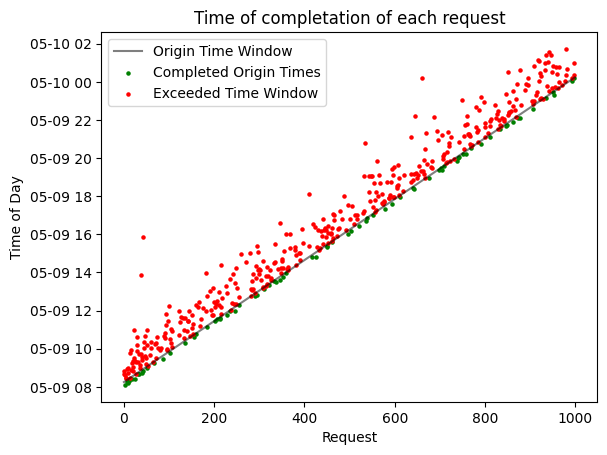

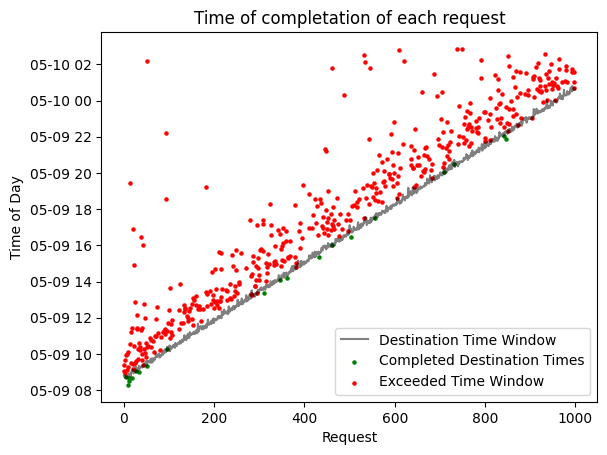

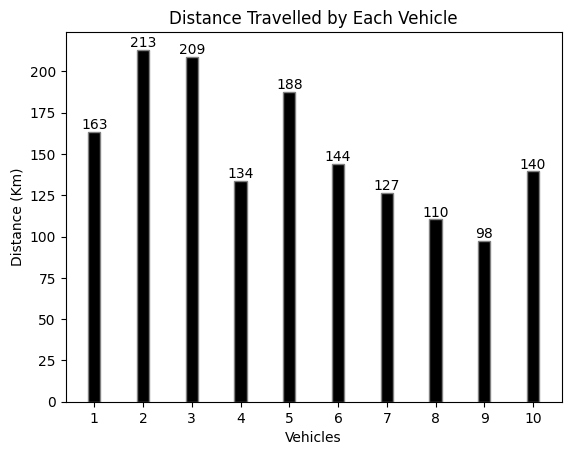

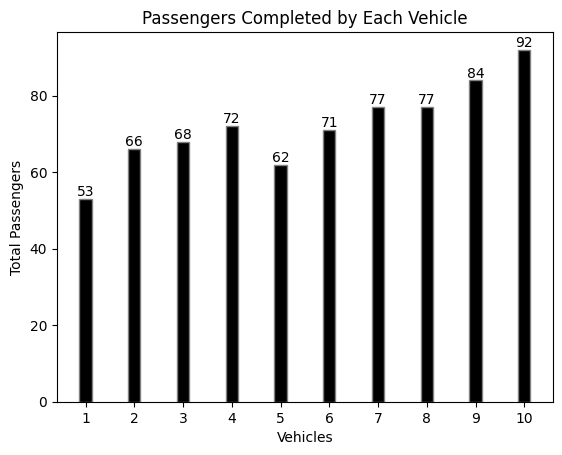

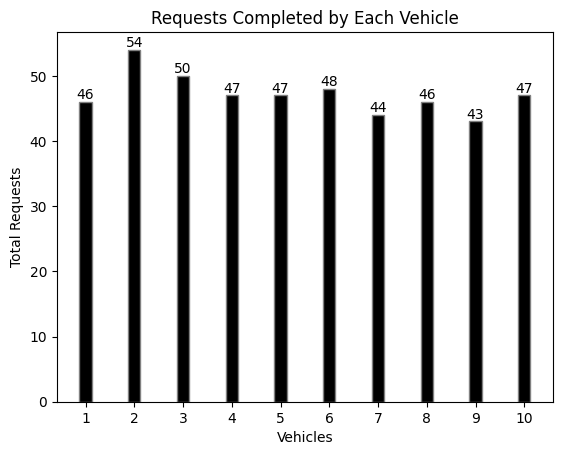

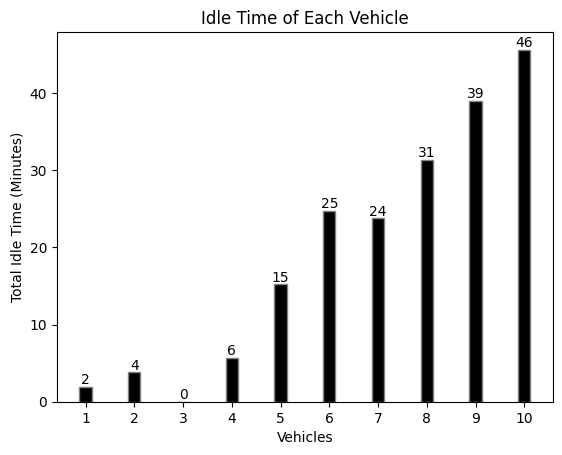

In [25]:
testEnv(algo8,10,1000,render_mode=None,requestFile="./EvalCases/r4.pkl",savePath="./EvalCases/T8_RL.pkl")
busHandlerT8 = pickle.load(open("./EvalCases/T8_RL.pkl","rb"))
vehicleListT8 = busHandlerT8.vehicles
requestListT8 = busHandlerT8.requests
plotTimeWindows(vehicleListT8,requestListT8,"./Figures/RL_Results/T8/RL_T8_")
plotVehicleStats(vehicleListT8,requestListT8,"./Figures/RL_Results/T8/RL_T8_")

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] + 40.230000000000004 = [40.230000000000004, 40.230000000000004, 40.230000000000004, 40.230000000000004, 40.230000000000004, 40.230000000000004, 40.230000000000004, 40.230000000000004, 40.230000000000004, 40.230000000000004, 40.230000000000004, 40.230000000000004, 40.230000000000004, 40.230000000000004, 40.230000000000004, 40.230000000000004, 40.230000000000004, 40.230000000000004, 40.230000000000004, 40.230000000000004]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] + 21.723799999999997 = [21.723799999999997, 21.723799999999997, 21.723799999999997, 21.723799999999997, 21.723799999999997, 21.723799999999997, 21.723799999999997, 21.723799999999997, 21.723799999999997, 21.723799999999997, 21.723799999999997, 21.723799999999997, 21.723799999999997, 21.723799999999997, 21.723799999999997, 21.723799999999997, 21.723799999999997, 21.723799999999997, 21.723799999999997, 21.723799999999997]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 

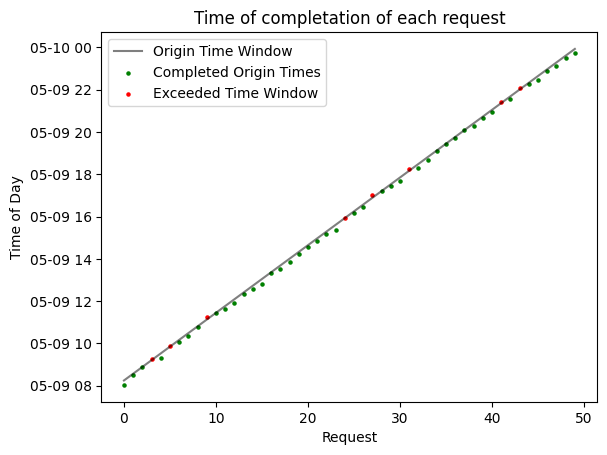

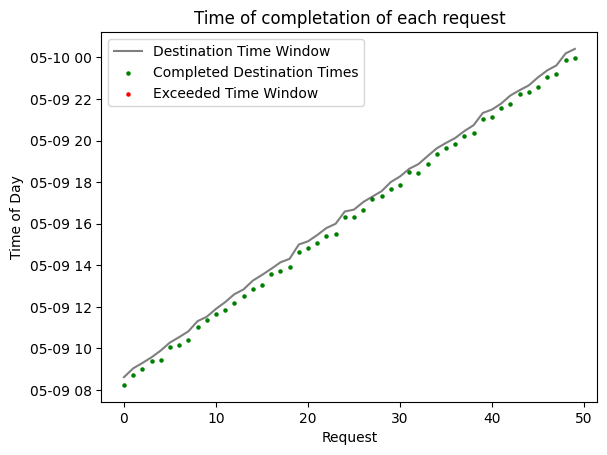

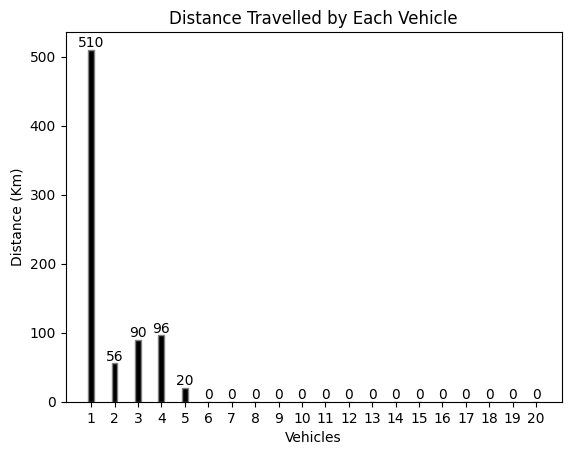

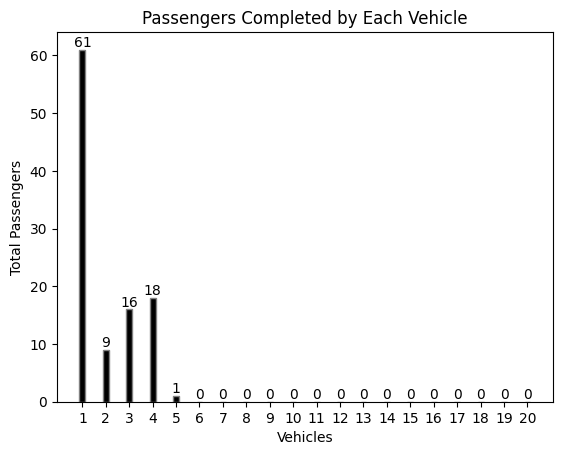

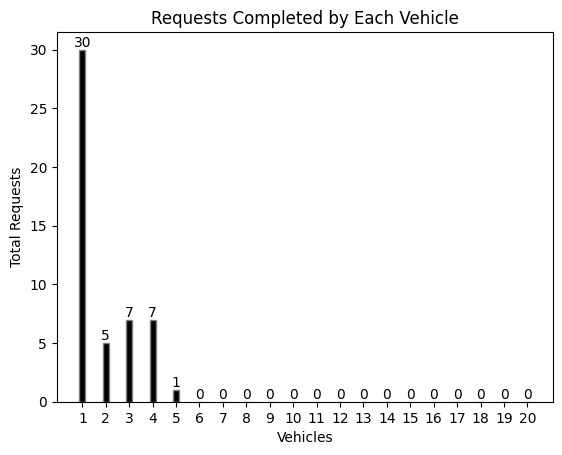

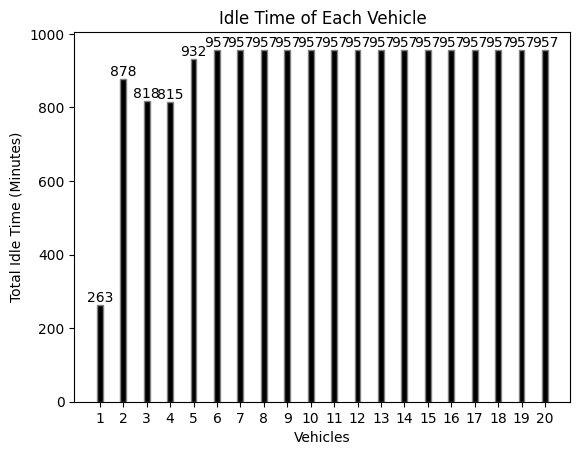

In [26]:
testEnv(algo9,20,50,render_mode=None,requestFile="./EvalCases/r1.pkl",savePath="./EvalCases/T9_RL.pkl")
busHandlerT9 = pickle.load(open("./EvalCases/T9_RL.pkl","rb"))
vehicleListT9 = busHandlerT9.vehicles
requestListT9 = busHandlerT9.requests
plotTimeWindows(vehicleListT9,requestListT9,"./Figures/RL_Results/T9/RL_T9_")
plotVehicleStats(vehicleListT9,requestListT9,"./Figures/RL_Results/T9/RL_T9_")

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] + 18.413800000000002 = [18.413800000000002, 18.413800000000002, 18.413800000000002, 18.413800000000002, 18.413800000000002, 18.413800000000002, 18.413800000000002, 18.413800000000002, 18.413800000000002, 18.413800000000002, 18.413800000000002, 18.413800000000002, 18.413800000000002, 18.413800000000002, 18.413800000000002, 18.413800000000002, 18.413800000000002, 18.413800000000002, 18.413800000000002, 18.413800000000002]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] + 0.7393835900002159 = [0.7393835900002159, 0.7393835900002159, 0.7393835900002159, 0.7393835900002159, 0.7393835900002159, 0.7393835900002159, 0.7393835900002159, 0.7393835900002159, 0.7393835900002159, 0.7393835900002159, 0.7393835900002159, 0.7393835900002159, 0.7393835900002159, 0.7393835900002159, 0.7393835900002159, 0.7393835900002159, 0.7393835900002159, 0.7393835900002159, 0.7393835900002159, 0.7393835900002159]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 

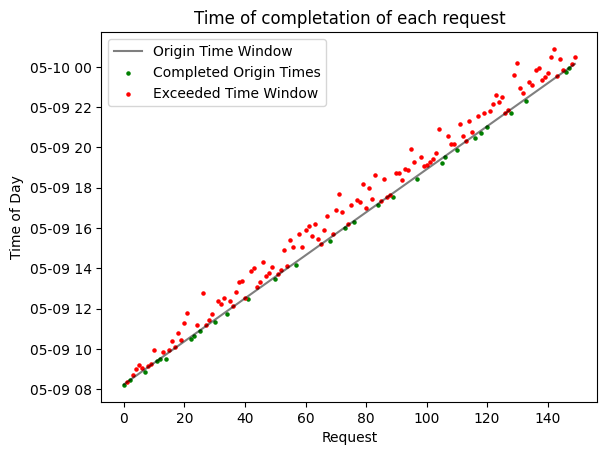

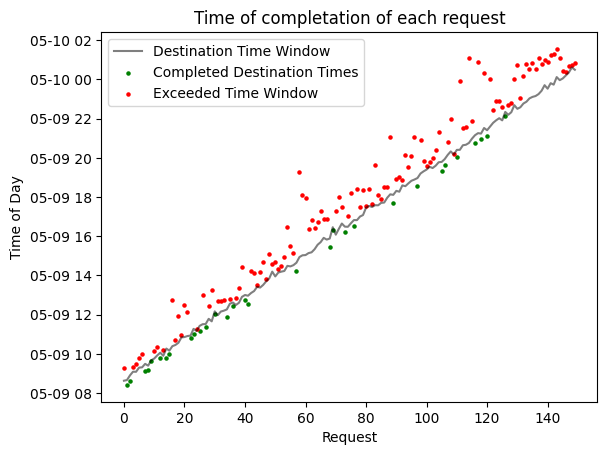

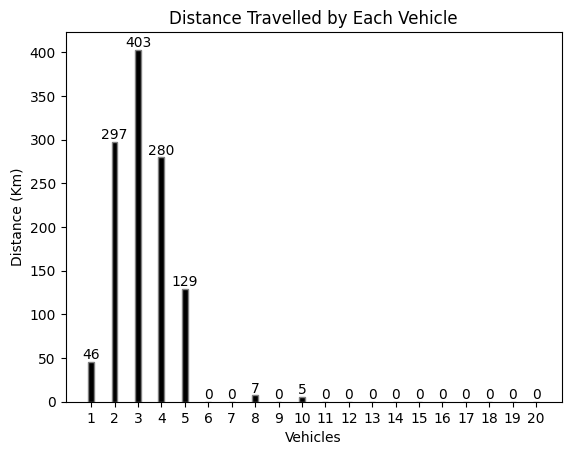

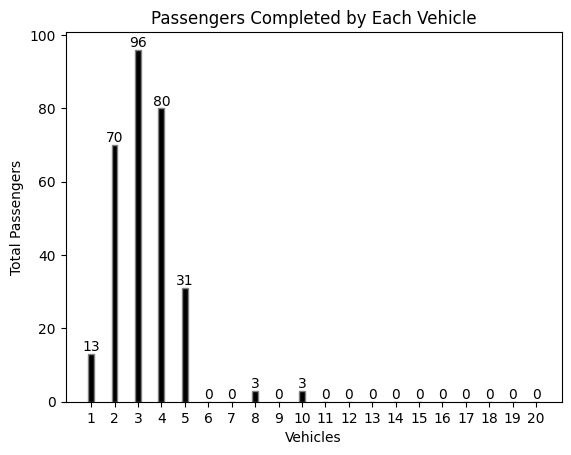

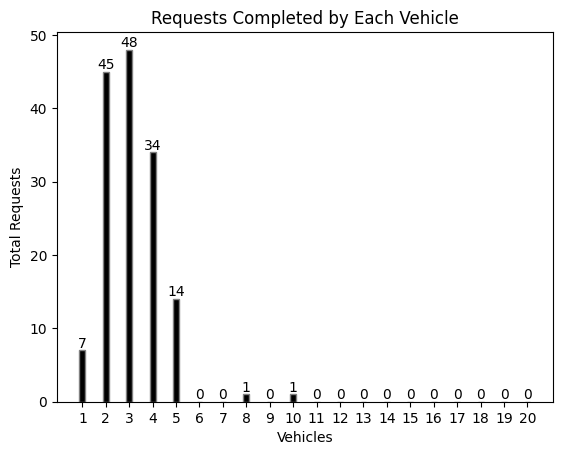

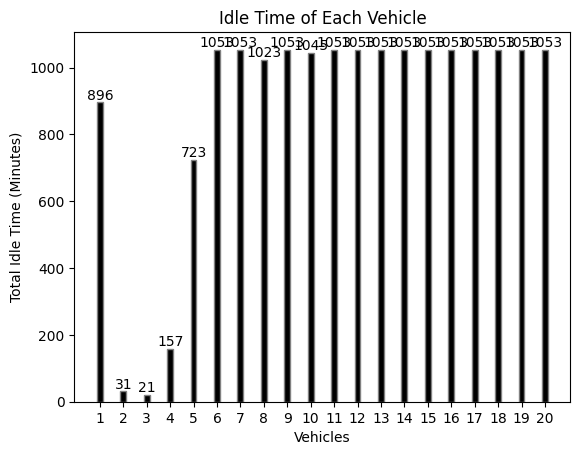

In [27]:
testEnv(algo10,20,150,render_mode=None,requestFile="./EvalCases/r2.pkl",savePath="./EvalCases/T10_RL.pkl")
busHandlerT10 = pickle.load(open("./EvalCases/T10_RL.pkl","rb"))
vehicleListT10 = busHandlerT10.vehicles
requestListT10 = busHandlerT10.requests
plotTimeWindows(vehicleListT10, requestListT10, "./Figures/RL_Results/T10/RL_T10_")
plotVehicleStats(vehicleListT10,requestListT10, "./Figures/RL_Results/T10/RL_T10_")

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] + 37.3952 = [37.3952, 37.3952, 37.3952, 37.3952, 37.3952, 37.3952, 37.3952, 37.3952, 37.3952, 37.3952, 37.3952, 37.3952, 37.3952, 37.3952, 37.3952, 37.3952, 37.3952, 37.3952, 37.3952, 37.3952]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] + 8.336399999992864 = [8.336399999992864, 8.336399999992864, 8.336399999992864, 8.336399999992864, 8.336399999992864, 8.336399999992864, 8.336399999992864, 8.336399999992864, 8.336399999992864, 8.336399999992864, 8.336399999992864, 8.336399999992864, 8.336399999992864, 8.336399999992864, 8.336399999992864, 8.336399999992864, 8.336399999992864, 8.336399999992864, 8.336399999992864, 8.336399999992864]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] + -151.36640994000118 = [-151.36640994000118, -151.36640994000118, -151.36640994000118, -151.36640994000118, -151.36640994000118, -151.36640994000118, -151.36640994000118, -151.36640994000118, -151.36640994000118, -151

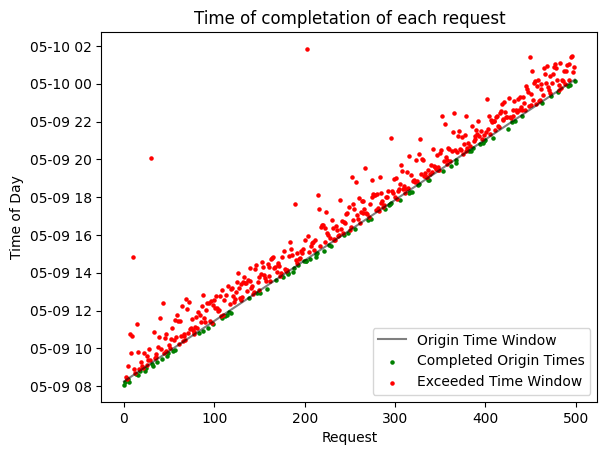

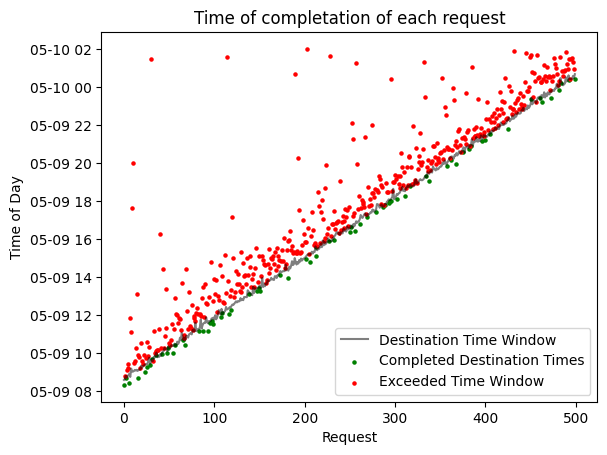

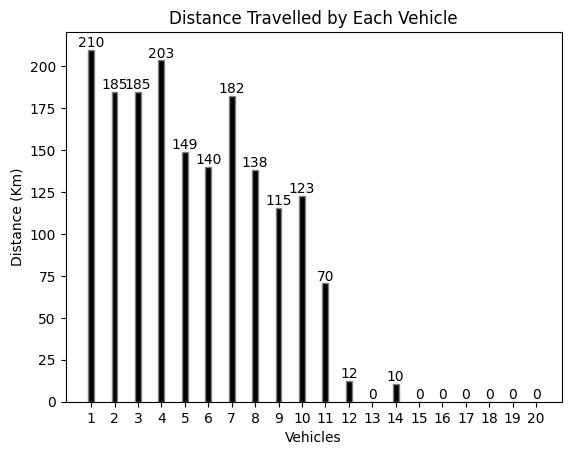

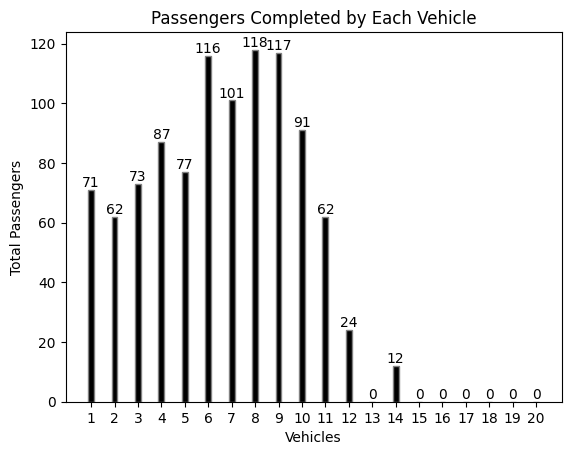

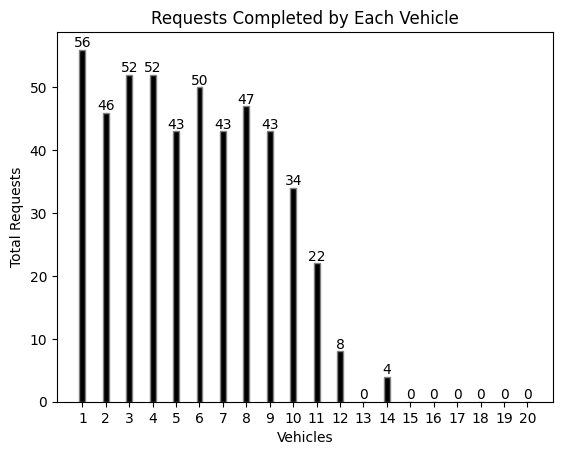

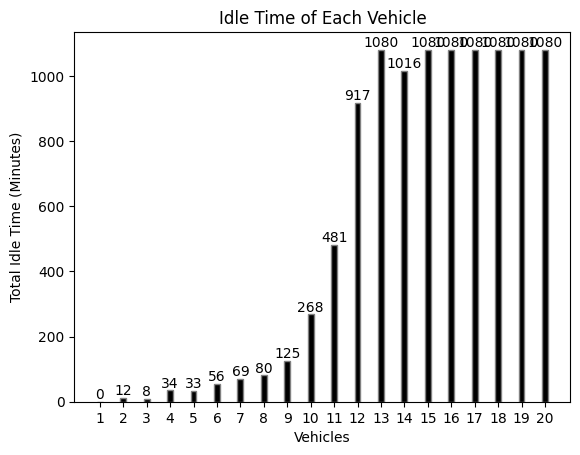

In [28]:
testEnv(algo11,20,500,render_mode=None,requestFile="./EvalCases/r3.pkl",savePath="./EvalCases/T11_RL.pkl")
busHandlerT11 = pickle.load(open("./EvalCases/T11_RL.pkl","rb"))
vehicleListT11 = busHandlerT11.vehicles
requestListT11 = busHandlerT11.requests
plotTimeWindows(vehicleListT11,requestListT11,"./Figures/RL_Results/T11/RL_T11_")
plotVehicleStats(vehicleListT11,requestListT11,"./Figures/RL_Results/T11/RL_T11_")

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] + 15.674 = [15.674, 15.674, 15.674, 15.674, 15.674, 15.674, 15.674, 15.674, 15.674, 15.674, 15.674, 15.674, 15.674, 15.674, 15.674, 15.674, 15.674, 15.674, 15.674, 15.674]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] + -78.65980000000127 = [-78.65980000000127, -78.65980000000127, -78.65980000000127, -78.65980000000127, -78.65980000000127, -78.65980000000127, -78.65980000000127, -78.65980000000127, -78.65980000000127, -78.65980000000127, -78.65980000000127, -78.65980000000127, -78.65980000000127, -78.65980000000127, -78.65980000000127, -78.65980000000127, -78.65980000000127, -78.65980000000127, -78.65980000000127, -78.65980000000127]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] + 36.99339999999938 = [36.99339999999938, 36.99339999999938, 36.99339999999938, 36.99339999999938, 36.99339999999938, 36.99339999999938, 36.99339999999938, 36.99339999999938, 36.99339999999938, 36.99339999999938, 36.99

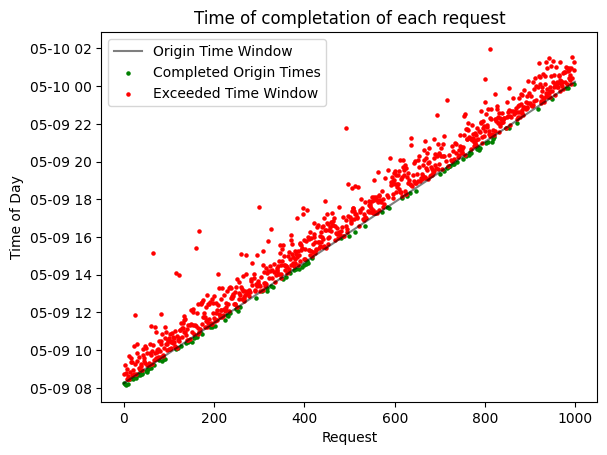

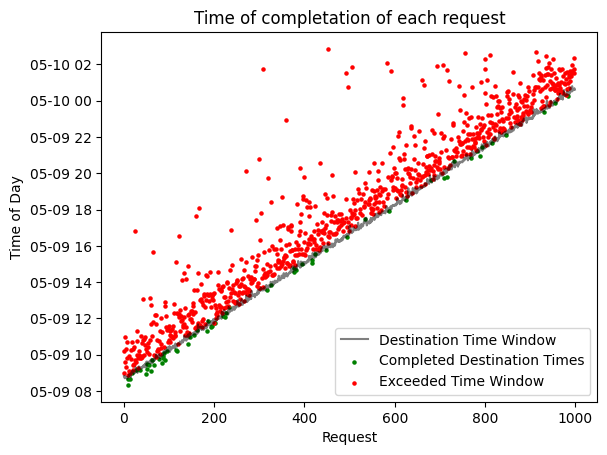

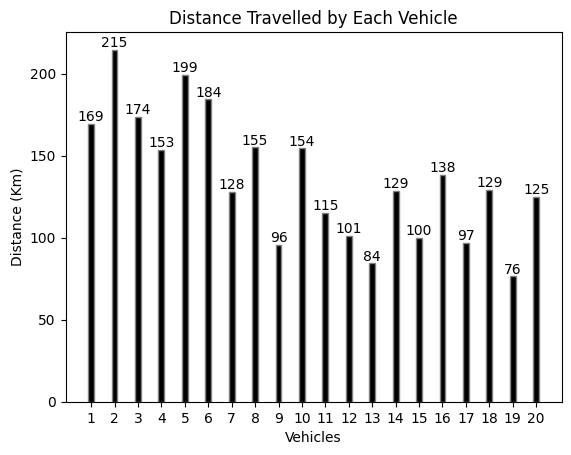

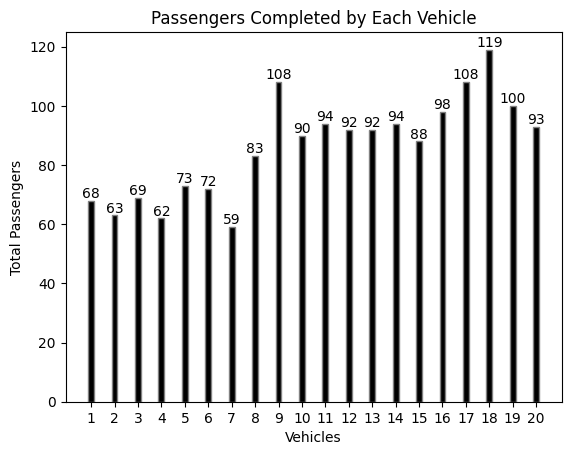

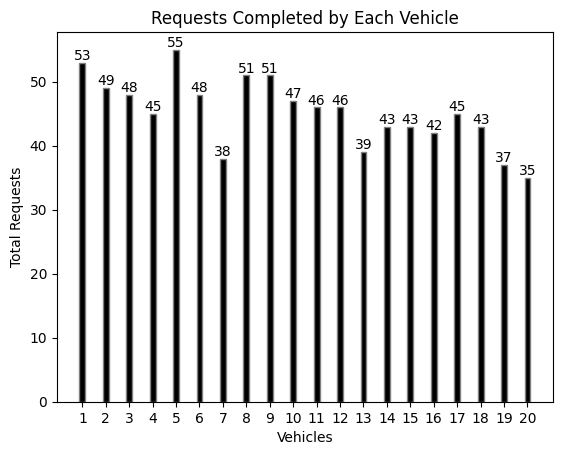

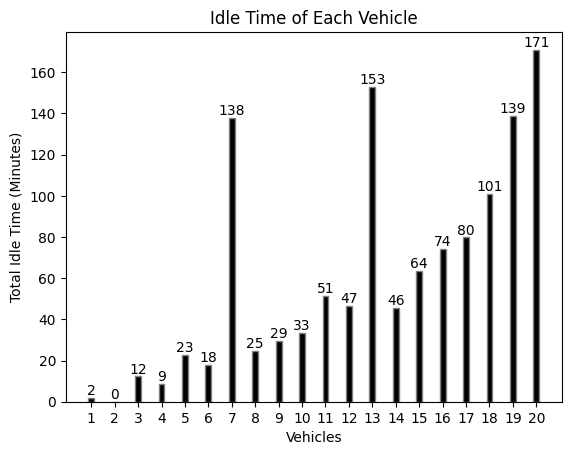

In [29]:
testEnv(algo12,20,1000,render_mode=None,requestFile="./EvalCases/r4.pkl",savePath="./EvalCases/T12_RL.pkl")
busHandlerT12 = pickle.load(open("./EvalCases/T12_RL.pkl","rb"))
vehicleListT12 = busHandlerT12.vehicles
requestListT12 = busHandlerT12.requests
plotTimeWindows(vehicleListT12,requestListT12,"./Figures/RL_Results/T12/RL_T12_")
plotVehicleStats(vehicleListT12,requestListT12,"./Figures/RL_Results/T12/RL_T12_")

In [30]:
#Complete a bar chart of each of the 10 vehicle's stats 

fig, ax = plt.subplots()
barWidth = 0.25
bars1 = [veh.stats._totalDistance/1000 for veh in test_env_unwrapped.busHandler.vehicles]
# bars2 = [veh.stats._totalTime/60 for veh in test_env_unwrapped.busHandler.vehicles]
bars3 = [veh.stats._totalPassengers for veh in test_env_unwrapped.busHandler.vehicles]
bars4 = [veh.stats._totalRequests for veh in test_env_unwrapped.busHandler.vehicles]
bars5 = [veh.stats._totalIdleTime/60 for veh in test_env.vehicles]


#Display bars1-4
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]

#Labels X-Axis and Y-Axis
ax.set_xlabel('Vehicles')
ax.set_ylabel('Distance (Km)')

#Make each bar have a vertical label
ax.set_xticks([r for r in range(len(bars1))])
ax.set_xticklabels([f"{i+1}" for i in range(len(bars1))])


ax.bar(r1, bars1, color='b', width=barWidth, edgecolor='grey', label='Distance')

In [31]:
fig, ax = plt.subplots()
barWidth = 0.25

#Labels X-Axis and Y-Axis
ax.set_xlabel('Vehicles')
ax.set_ylabel('Total Passengers')

#Make each bar have a vertical label
ax.set_xticks([r+barWidth for r in range(len(bars1))])
ax.set_xticklabels([f"{i+1}" for i in range(len(bars1))])

ax.bar(r2, bars3, color='r', width=barWidth, edgecolor='grey', label='Time')
# ax.bar(r3, bars3, color='g', width=barWidth, edgecolor='grey', label='Passengers')
# ax.bar(r4, bars4, color='y', width=barWidth, edgecolor='grey', label='Requests')

In [32]:
fig, ax = plt.subplots()
barWidth = 0.25

#Labels X-Axis and Y-Axis
ax.set_xlabel('Vehicles')
ax.set_ylabel('Total Requests')

#Make each bar have a vertical label
ax.set_xticks([r for r in range(len(bars1))])
ax.set_xticklabels([f"{i+1}" for i in range(len(bars1))])

ax.bar(r1, bars4, color='b', width=barWidth, edgecolor='grey', label='Distance')

In [33]:
fig, ax = plt.subplots()
barWidth = 0.25
#Labels X-Axis and Y-Axis
ax.set_xlabel('Vehicles')
ax.set_ylabel('Idle Time (Minutes)')

#Make each bar have a vertical label
ax.set_xticks([r+barWidth for r in range(len(bars1))])
ax.set_xticklabels([f"{i+1}" for i in range(len(bars1))])

ax.bar(r2, bars5, color='r', width=barWidth, edgecolor='grey', label='Time')